In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Dense, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D, Input
from tensorflow.keras import Model,models
from tensorflow.keras.applications import InceptionV3

In [2]:
tf.__version__

'2.3.1'

In [3]:
InceptionModel = InceptionV3(include_top=True,weights='imagenet')
tf.keras.utils.plot_model(InceptionModel, to_file='GoogleNet.png', show_shapes=True)
InceptionModel.summary()

                 
__________________________________________________________________________________________________
batch_normalization_63 (BatchNo (None, 17, 17, 192)  576         conv2d_63[0][0]                  
__________________________________________________________________________________________________
batch_normalization_68 (BatchNo (None, 17, 17, 192)  576         conv2d_68[0][0]                  
__________________________________________________________________________________________________
batch_normalization_69 (BatchNo (None, 17, 17, 192)  576         conv2d_69[0][0]                  
__________________________________________________________________________________________________
activation_60 (Activation)      (None, 17, 17, 192)  0           batch_normalization_60[0][0]     
__________________________________________________________________________________________________
activation_63 (Activation)      (None, 17, 17, 192)  0           batch_normalization_63[0][

In [4]:
featureExtractor = Model(InceptionModel.input,InceptionModel.get_layer('mixed7').output)

In [5]:
featureExtractor.summary()

                   
__________________________________________________________________________________________________
batch_normalization_44 (BatchNo (None, None, None, 1 480         conv2d_44[0][0]                  
__________________________________________________________________________________________________
activation_44 (Activation)      (None, None, None, 1 0           batch_normalization_44[0][0]     
__________________________________________________________________________________________________
conv2d_45 (Conv2D)              (None, None, None, 1 179200      activation_44[0][0]              
__________________________________________________________________________________________________
batch_normalization_45 (BatchNo (None, None, None, 1 480         conv2d_45[0][0]                  
__________________________________________________________________________________________________
activation_45 (Activation)      (None, None, None, 1 0           batch_normalization_45[0

In [32]:
class PixelRPN(Model):
    def __init__(self):
        super(PixelRPN,self).__init__()
        # input size is about 17*17*768 but larger
        self.conv2d_condense1 = Conv2D(384,(1,1),padding='same',activation='relu')
        self.batch_norm1 = BatchNormalization()
        # if we set this number too small, it creates information bottleneck
        # if it's high, we cannot use resnet connection
        self.conv2d_condense2 = Conv2D(96,(1,1),padding='same',activation='relu')
        self.batch_norm2 = BatchNormalization()
        # note that the effective receptive field most likely cover entire image here
        # so every single feature position has the potential to produce bounding box anywhere in the image

        self.conv2d_extract2a = Conv2D(96,(2,2),padding='valid',activation='relu')
        self.batch_norm_extract2a = BatchNormalization()
        self.conv2d_extract2b = Conv2D(96,(1,1),activation='relu')
        self.batch_norm_extract2b = BatchNormalization()

        self.conv2d_extract3a = Conv2D(96,(3,3),padding='valid',activation='relu')
        self.batch_norm_extract3a = BatchNormalization()
        self.conv2d_extract3b = Conv2D(96,(1,1),activation='relu')
        self.batch_norm_extract3b = BatchNormalization()

        self.conv2d_extract5a = Conv2D(96,(5,5),strides=(2,2),padding='valid',activation='relu')
        self.batch_norm_extract5a = BatchNormalization()
        self.conv2d_extract5b = Conv2D(96,(1,1),activation='relu')
        self.batch_norm_extract5b = BatchNormalization()

        self.conv2d_extract8a = Conv2D(96,(8,8),strides=(3,3),padding='valid',activation='relu')
        self.batch_norm_extract8a = BatchNormalization()
        self.conv2d_extract8b = Conv2D(96,(1,1),activation='relu')
        self.batch_norm_extract8b = BatchNormalization()

        self.conv2d_extract12a = Conv2D(96,(12,12),strides=(5,5),activation='relu')
        self.batch_norm_extract12a = BatchNormalization()
        self.conv2d_extract12b = Conv2D(96,(1,1),activation='relu')
        self.batch_norm_extract12b = BatchNormalization()

        # we need better gradient flow

        self.classifier1 = Conv2D(96,(1,1),activation='relu')
        self.batch_norm_classify1 = BatchNormalization()
        # use resnet connection here to optimize gradient flow
        self.classifier2 = Conv2D(96,(1,1),activation='relu')
        self.batch_norm_classify2 = BatchNormalization()
        self.classifier3 = Conv2D(1,(1,1),activation='sigmoid')


    def call(self, input_tensor, training=False):
        features = self.conv2d_condense1(input_tensor)
        features = self.batch_norm1(features)
        features = self.conv2d_condense2(features)
        features = self.batch_norm2(features)

        extract2 = self.conv2d_extract2a(features)
        extract2 = self.batch_norm_extract2a(extract2)
        extract2 = self.conv2d_extract2b(extract2)
        extract2 = self.batch_norm_extract2b(extract2)

        extract3 = self.conv2d_extract3a(features)
        extract3 = self.batch_norm_extract3a(extract3)
        extract3 = self.conv2d_extract3b(extract3)
        extract3 = self.batch_norm_extract3b(extract3)

        extract5 = self.conv2d_extract5a(features)
        extract5 = self.batch_norm_extract5a(extract5)
        extract5 = self.conv2d_extract5b(extract5)
        extract5 = self.batch_norm_extract5b(extract5)

        extract8 = self.conv2d_extract8a(features)
        extract8 = self.batch_norm_extract8a(extract8)
        extract8 = self.conv2d_extract8b(extract8)
        extract8 = self.batch_norm_extract8b(extract8)

        extract12 = self.conv2d_extract12a(features)
        extract12 = self.batch_norm_extract12a(extract12)
        extract12 = self.conv2d_extract12b(extract12)
        extract12 = self.batch_norm_extract12b(extract12)

        extract2New = self.classifier1(extract2)
        extract2New = self.batch_norm_classify1(extract2New)
        extract2New = self.classifier2(extract2New)
        extract2New = self.batch_norm_classify2(extract2New)
        extract2 = extract2 + extract2New
        extract2 = self.classifier3(extract2)

        extract3New = self.classifier1(extract3)
        extract3New = self.batch_norm_classify1(extract3New)
        extract3New = self.classifier2(extract3New)
        extract3New = self.batch_norm_classify2(extract3New)
        extract3 = extract3 + extract3New
        extract3 = self.classifier3(extract3)

        extract5New = self.classifier1(extract5)
        extract5New = self.batch_norm_classify1(extract5New)
        extract5New = self.classifier2(extract5New)
        extract5New = self.batch_norm_classify2(extract5New)
        extract5 = extract5 + extract5New
        extract5 = self.classifier3(extract5)

        extract8New = self.classifier1(extract8)
        extract8New = self.batch_norm_classify1(extract8New)
        extract8New = self.classifier2(extract8New)
        extract8New = self.batch_norm_classify2(extract8New)
        extract8 = extract8 + extract8New
        extract8 = self.classifier3(extract8)

        extract12New = self.classifier1(extract12)
        extract12New = self.batch_norm_classify1(extract12New)
        extract12New = self.classifier2(extract12New)
        extract12New = self.batch_norm_classify2(extract12New)
        extract12 = extract12 + extract12New
        extract12 = self.classifier3(extract12)
        # if we consider each pixel as an region proposal
        # there's at least 775 regions proposed for a single image

        return [extract2,extract3,extract5,extract8,extract12]

    def build_graph(self, input_shape):
        x = Input(shape=input_shape)
        return Model(inputs=[x], outputs=self.call(x))
        

In [33]:
proposer = PixelRPN()

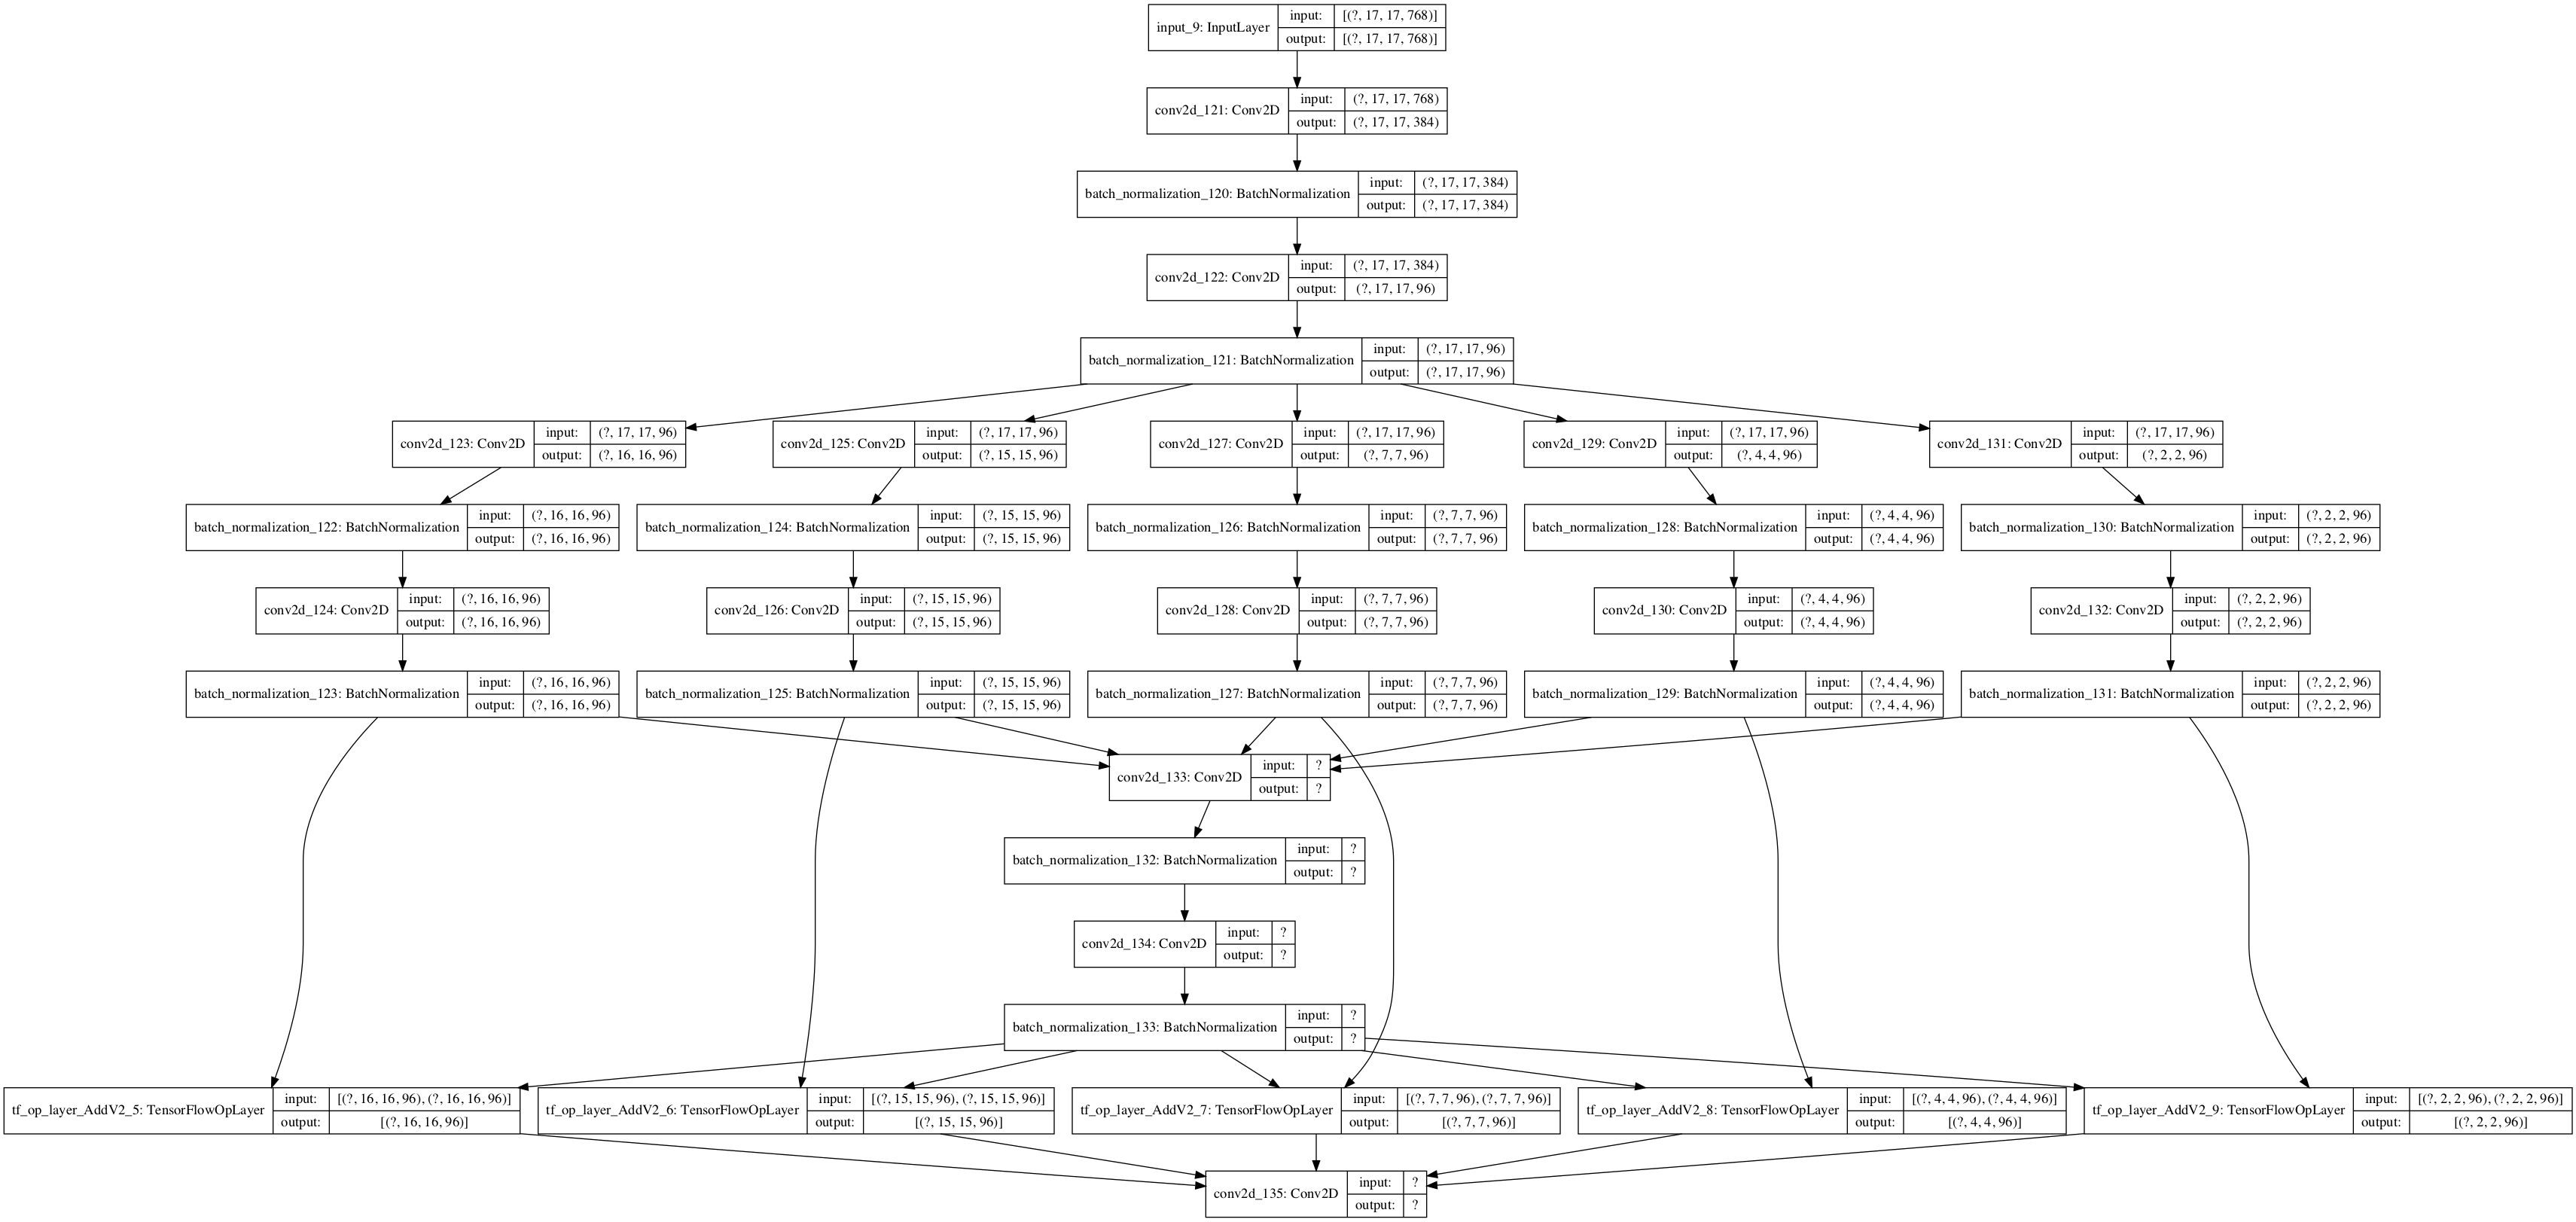

In [18]:
tf.keras.utils.plot_model(proposer.build_graph((17,17,768)), to_file='PixelRPN.png', show_layer_names=True,show_shapes=True)

In [58]:
output = proposer(tf.zeros((10,45,17,768)))
print(output[0].shape)

(10, 44, 16, 1)


In [61]:
proposer.summary()

Model: "pixel_rpn_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_181 (Conv2D)          multiple                  295296    
_________________________________________________________________
batch_normalization_176 (Bat multiple                  1536      
_________________________________________________________________
conv2d_182 (Conv2D)          multiple                  36960     
_________________________________________________________________
batch_normalization_177 (Bat multiple                  384       
_________________________________________________________________
conv2d_183 (Conv2D)          multiple                  36960     
_________________________________________________________________
batch_normalization_178 (Bat multiple                  384       
_________________________________________________________________
conv2d_184 (Conv2D)          multiple                  

In [44]:
class RCNN(Model):
    @tf.function(input_signature=[tf.TensorSpec(shape=(3), dtype=tf.int64),tf.TensorSpec(shape=(), dtype=tf.int32)])
    def getROIfeature(self,inputs,size):
        label = inputs[0]
        r = inputs[1]
        c = inputs[2]
        r*=self.strideSizes[size]
        c*=self.strideSizes[size]
        rEnd=r+self.extraSizes[size]
        cEnd=c+self.extraSizes[size]
        return self.features[label,r:rEnd,c:cEnd,:]

    @tf.function(input_signature=[tf.TensorSpec(shape=(3), dtype=tf.int64)])
    def getROIfeature2(self,inputs):
        return self.getROIfeature(inputs,tf.constant(2))
    @tf.function(input_signature=[tf.TensorSpec(shape=(3), dtype=tf.int64)])
    def getROIfeature3(self,inputs):
        return self.getROIfeature(inputs,tf.constant(3))
    @tf.function(input_signature=[tf.TensorSpec(shape=(3), dtype=tf.int64)])
    def getROIfeature5(self,inputs):
        return self.getROIfeature(inputs,tf.constant(5))
    @tf.function(input_signature=[tf.TensorSpec(shape=(3), dtype=tf.int64)])
    def getROIfeature8(self,inputs):
        return self.getROIfeature(inputs,tf.constant(8))
    @tf.function(input_signature=[tf.TensorSpec(shape=(3), dtype=tf.int64)])
    def getROIfeature12(self,inputs):
        return self.getROIfeature(inputs,tf.constant(12))

    def __init__(self):
        super(RCNN,self).__init__()
        self.extraSizes=tf.constant([0,0,3,5,0,8,0,0,12,0,0,0,17],dtype=tf.int64)
        self.strideSizes = tf.constant([0,0,1,1,0,2,0,0,3,0,0,0,5],dtype=tf.int64)
        # takes input of (17,17,768) or larger
        self.conv2d_condense1 = Conv2D(384,(1,1),padding='same',activation='relu')
        self.batch_norm1 = BatchNormalization()
        # if we set this number too small, it creates information bottleneck
        # if it's high, we cannot use resnet connection
        self.conv2d_condense2 = Conv2D(192,(3,3),padding='same',activation='relu')
        self.batch_norm2 = BatchNormalization()

        # to ensure environment is sufficiently considered, look at the window with 17*17 for a 12*12 pixel
        # 12->17
        # 8->12
        # 5->8
        # 3->5
        # 2->3
        self.conv2d_extract12_condense = Conv2D(144,(1,1),activation='relu')
        self.batch_norm_extract12a = BatchNormalization()
        self.conv2d_extract12 = Conv2D(48,(9,9),strides=(4,4),activation='relu')
        self.batch_norm_extract12b = BatchNormalization()
        self.maxpool_extract17_3 = MaxPooling2D((9,9),strides=(4,4))

        self.conv2d_extract8_condense = Conv2D(144,(1,1),activation='relu')
        self.batch_norm_extract8a = BatchNormalization()
        self.conv2d_extract8 = Conv2D(48,(6,6),strides=(3,3),activation='relu')
        self.batch_norm_extract8b = BatchNormalization()
        self.maxpool_extract12_3 = MaxPooling2D((6,6),strides=(3,3))

        self.conv2d_extract5_condense = Conv2D(144,(1,1),activation='relu')
        self.batch_norm_extract5a = BatchNormalization()
        self.conv2d_extract5 = Conv2D(48,(4,4),strides=(2,2),activation='relu')
        self.batch_norm_extract5b = BatchNormalization()
        self.maxpool_extract8_3 = MaxPooling2D((4,4),strides=(2,2))

        self.conv2d_extract3_condense = Conv2D(144,(1,1),activation='relu')
        self.batch_norm_extract3a = BatchNormalization()
        self.conv2d_extract3 = Conv2D(48,(3,3),strides=(1,1),activation='relu')
        self.batch_norm_extract3b = BatchNormalization()
        self.maxpool_extract5_3 = MaxPooling2D((3,3),strides=(1,1))

        self.conv2d_extract2_condense = Conv2D(144,(1,1),activation='relu')
        self.batch_norm_extract2a = BatchNormalization()
        self.conv2d_extract2 = Conv2D(48,(1,1),activation='relu')
        self.batch_norm_extract2b = BatchNormalization()

        self.flatten = Flatten()

        self.classifier1 = Dense(256, activation='relu')
        self.classifier2 = Dense(64, activation='relu')
        self.classifier3 = Dense(3, activation='softmax')

        self.regressor1 = Dense(256, activation='relu')
        self.regressor2 = Dense(256, activation='relu')
        self.regressor3 = Dense(4, activation='linear')

    def call(self, inputs, training=False):
        input_features = inputs[0]
        pixel_objectness = inputs[1]
        extract2,extract3,extract5,extract8,extract12 = pixel_objectness
        # ignore extract0 for now

        self.features = self.conv2d_condense1(input_features)
        self.features = self.batch_norm1(self.features)
        self.features = self.conv2d_condense2(self.features)
        self.features = self.batch_norm2(self.features)
        num_channels = self.features.shape[-1]

        pad_size=5
        self.features = tf.pad(self.features,[[0,0],[0,pad_size],[0,pad_size],[0,0]],'CONSTANT')

        # extract2
        extract2 = extract2[:,:,:,0]
        filtered2 = tf.where(extract2>0.5)
        shape2 = (3,3,192)
        if filtered2.shape[0]==0:
            features2 = tf.zeros((0,*shape2))
        else:
            features2 = tf.map_fn(self.getROIfeature2,filtered2,fn_output_signature=tf.TensorSpec(shape=shape2, dtype=tf.float32))
        # expected shape (new_batch_size,3,3,#channels)

        features2Condensed = self.conv2d_extract2_condense(features2)
        features2Condensed = self.batch_norm_extract2a(features2Condensed)
        features2 = self.conv2d_extract2(features2Condensed)
        features2 = self.batch_norm_extract2b(features2)
        features2 = tf.concat([features2Condensed,features2],axis=-1)

        extract3 = extract3[:,:,:,0]
        filtered3 = tf.where(extract3>0.5)
        shape3 = (5,5,192)
        if filtered3.shape[0]==0:
            features3 = tf.zeros((0,*shape3))
        else:
            features3 = tf.map_fn(self.getROIfeature3,filtered3,fn_output_signature=tf.TensorSpec(shape=shape3, dtype=tf.float32))

        features3Condensed = self.conv2d_extract3_condense(features3)
        features3Condensed = self.batch_norm_extract3a(features3Condensed)
        features3 = self.conv2d_extract3(features3Condensed)
        features3 = self.batch_norm_extract3b(features3)
        features3Condensed = self.maxpool_extract5_3(features3Condensed)
        features3 = tf.concat([features3Condensed,features3],axis=-1)

        extract5 = extract5[:,:,:,0]
        filtered5 = tf.where(extract5>0.5)
        shape5 = (8,8,192)
        if filtered5.shape[0]==0:
            features5 = tf.zeros((0,*shape5))
        else:
            features5 = tf.map_fn(self.getROIfeature5,filtered5,fn_output_signature=tf.TensorSpec(shape=shape5, dtype=tf.float32))

        features5Condensed = self.conv2d_extract5_condense(features5)
        features5Condensed = self.batch_norm_extract5a(features5Condensed)
        features5 = self.conv2d_extract5(features5Condensed)
        features5 = self.batch_norm_extract5b(features5)
        features5Condensed = self.maxpool_extract8_3(features5Condensed)
        features5 = tf.concat([features5Condensed,features5],axis=-1)

        extract8 = extract8[:,:,:,0]
        filtered8 = tf.where(extract8>0.5)
        shape8 = (12,12,192)
        if filtered8.shape[0]==0:
            features8 = tf.zeros((0,*shape8))
        else:
            features8 = tf.map_fn(self.getROIfeature8,filtered8,fn_output_signature=tf.TensorSpec(shape=shape8, dtype=tf.float32))

        features8Condensed = self.conv2d_extract8_condense(features8)
        features8Condensed = self.batch_norm_extract8a(features8Condensed)
        features8 = self.conv2d_extract8(features8Condensed)
        features8 = self.batch_norm_extract8b(features8)
        features8Condensed = self.maxpool_extract12_3(features8Condensed)
        features8 = tf.concat([features8Condensed,features8],axis=-1)

        extract12 = extract12[:,:,:,0]
        filtered12 = tf.where(extract12>0.5)
        shape12 = (17,17,192)
        if filtered12.shape[0]==0:
            features12 = tf.zeros((0,*shape12))
        else:
            features12 = tf.map_fn(self.getROIfeature12,filtered12,fn_output_signature=tf.TensorSpec(shape=shape12, dtype=tf.float32))

        features12Condensed = self.conv2d_extract12_condense(features12)
        features12Condensed = self.batch_norm_extract12a(features12Condensed)
        features12 = self.conv2d_extract12(features12Condensed)
        features12 = self.batch_norm_extract12b(features12)
        features12Condensed = self.maxpool_extract17_3(features12Condensed)
        features12 = tf.concat([features12Condensed,features12],axis=-1)

        features2 = self.flatten(features2)
        features3 = self.flatten(features3)
        features5 = self.flatten(features5)
        features8 = self.flatten(features8)
        features12 = self.flatten(features12)
        
        class2 = self.classifier1(features2)
        class3 = self.classifier1(features3)
        class5 = self.classifier1(features5)
        class8 = self.classifier1(features8)
        class12 = self.classifier1(features12)

        class2 = self.classifier2(class2)
        class3 = self.classifier2(class3)
        class5 = self.classifier2(class5)
        class8 = self.classifier2(class8)
        class12 = self.classifier2(class12)

        class2 = self.classifier3(class2)
        class3 = self.classifier3(class3)
        class5 = self.classifier3(class5)
        class8 = self.classifier3(class8)
        class12 = self.classifier3(class12)

        regress2 = self.regressor1(features2)
        regress3 = self.regressor1(features3)
        regress5 = self.regressor1(features5)
        regress8 = self.regressor1(features8)
        regress12 = self.regressor1(features12)

        regress2 = self.regressor2(regress2)
        regress3 = self.regressor2(regress3)
        regress5 = self.regressor2(regress5)
        regress8 = self.regressor2(regress8)
        regress12 = self.regressor2(regress12)

        regress2 = self.regressor3(regress2)
        regress3 = self.regressor3(regress3)
        regress5 = self.regressor3(regress5)
        regress8 = self.regressor3(regress8)
        regress12 = self.regressor3(regress12)
        # post processing using position information and returning
        # try optimize gradient flow
        return [[class2,regress2,filtered2],[class3,regress3,filtered3],[class5,regress5,filtered5],[class8,regress8,filtered8],[class12,regress12,filtered12]]

    def build_graph(self, input_shape):
        features = Input(shape=input_shape)
        objectness = [Input(shape=(16,16,1)),Input(shape=(15,15,1)),Input(shape=(7,7,1)),Input(shape=(4,4,1)),Input(shape=(2,2,1))]
        return Model(inputs=[features,*objectness], outputs=self([features,objectness]))


In [45]:
analyzer = RCNN()

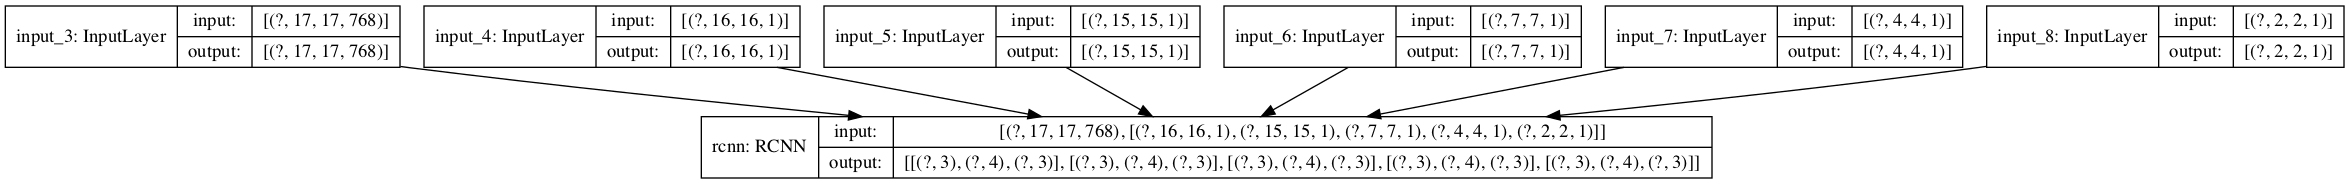

In [11]:
tf.keras.utils.plot_model(analyzer.build_graph((17,17,768)), to_file='RCNN.png', show_layer_names=True,show_shapes=True)

In [47]:
analyzer([tf.zeros((1,17,17,768)),[tf.zeros((1,16,16,1)),tf.zeros((1,15,15,1)),tf.zeros((1,7,7,1)),tf.zeros((1,4,4,1)),tf.zeros((1,2,2,1))]])

[[<tf.Tensor: shape=(0, 3), dtype=float32, numpy=array([], shape=(0, 3), dtype=float32)>,
  <tf.Tensor: shape=(0, 4), dtype=float32, numpy=array([], shape=(0, 4), dtype=float32)>,
  <tf.Tensor: shape=(0, 3), dtype=int64, numpy=array([], shape=(0, 3), dtype=int64)>],
 [<tf.Tensor: shape=(0, 3), dtype=float32, numpy=array([], shape=(0, 3), dtype=float32)>,
  <tf.Tensor: shape=(0, 4), dtype=float32, numpy=array([], shape=(0, 4), dtype=float32)>,
  <tf.Tensor: shape=(0, 3), dtype=int64, numpy=array([], shape=(0, 3), dtype=int64)>],
 [<tf.Tensor: shape=(0, 3), dtype=float32, numpy=array([], shape=(0, 3), dtype=float32)>,
  <tf.Tensor: shape=(0, 4), dtype=float32, numpy=array([], shape=(0, 4), dtype=float32)>,
  <tf.Tensor: shape=(0, 3), dtype=int64, numpy=array([], shape=(0, 3), dtype=int64)>],
 [<tf.Tensor: shape=(0, 3), dtype=float32, numpy=array([], shape=(0, 3), dtype=float32)>,
  <tf.Tensor: shape=(0, 4), dtype=float32, numpy=array([], shape=(0, 4), dtype=float32)>,
  <tf.Tensor: shape

In [48]:
analyzer.summary()

Model: "rcnn_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_196 (Conv2D)          multiple                  295296    
_________________________________________________________________
batch_normalization_190 (Bat multiple                  1536      
_________________________________________________________________
conv2d_197 (Conv2D)          multiple                  663744    
_________________________________________________________________
batch_normalization_191 (Bat multiple                  768       
_________________________________________________________________
conv2d_198 (Conv2D)          multiple                  27792     
_________________________________________________________________
batch_normalization_192 (Bat multiple                  576       
_________________________________________________________________
conv2d_199 (Conv2D)          multiple                  55992